In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import pickle as pkl
import seaborn as sns
import tensorflow as tf
import plotly.express as px
from RNN import *
tf.config.experimental.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


# Visualização inicial dos dados

In [3]:
df_orig = pd.read_csv("Data/SBGL_Weather_Data.csv")
df = df_orig.copy()
df.tail(5)

,valid_time_gmt,day_ind,temp,icon_extd,wx_phrase,dewPt,heat_index,rh,pressure,vis,wc,wdir,wdir_cardinal,wspd,feels_like,uv_index
237940,2024-08-11 16:00,D,73.0,3400,Fair,54.0,73.0,50.0,29.95,6.0,73.0,70.0,ENE,7.0,73.0,1.0
237941,2024-08-11 17:00,D,72.0,3400,Fair,54.0,72.0,53.0,29.95,6.0,72.0,40.0,NE,5.0,72.0,0.0
237942,2024-08-11 18:00,N,68.0,3300,Fair,57.0,68.0,68.0,29.98,6.0,68.0,130.0,SE,8.0,68.0,0.0
237943,2024-08-11 19:00,N,68.0,3300,Fair,57.0,68.0,68.0,29.98,6.0,68.0,140.0,SE,9.0,68.0,0.0
237944,2024-08-11 20:00,N,66.0,3300,Fair,59.0,66.0,78.0,30.01,6.0,66.0,140.0,SE,8.0,66.0,0.0


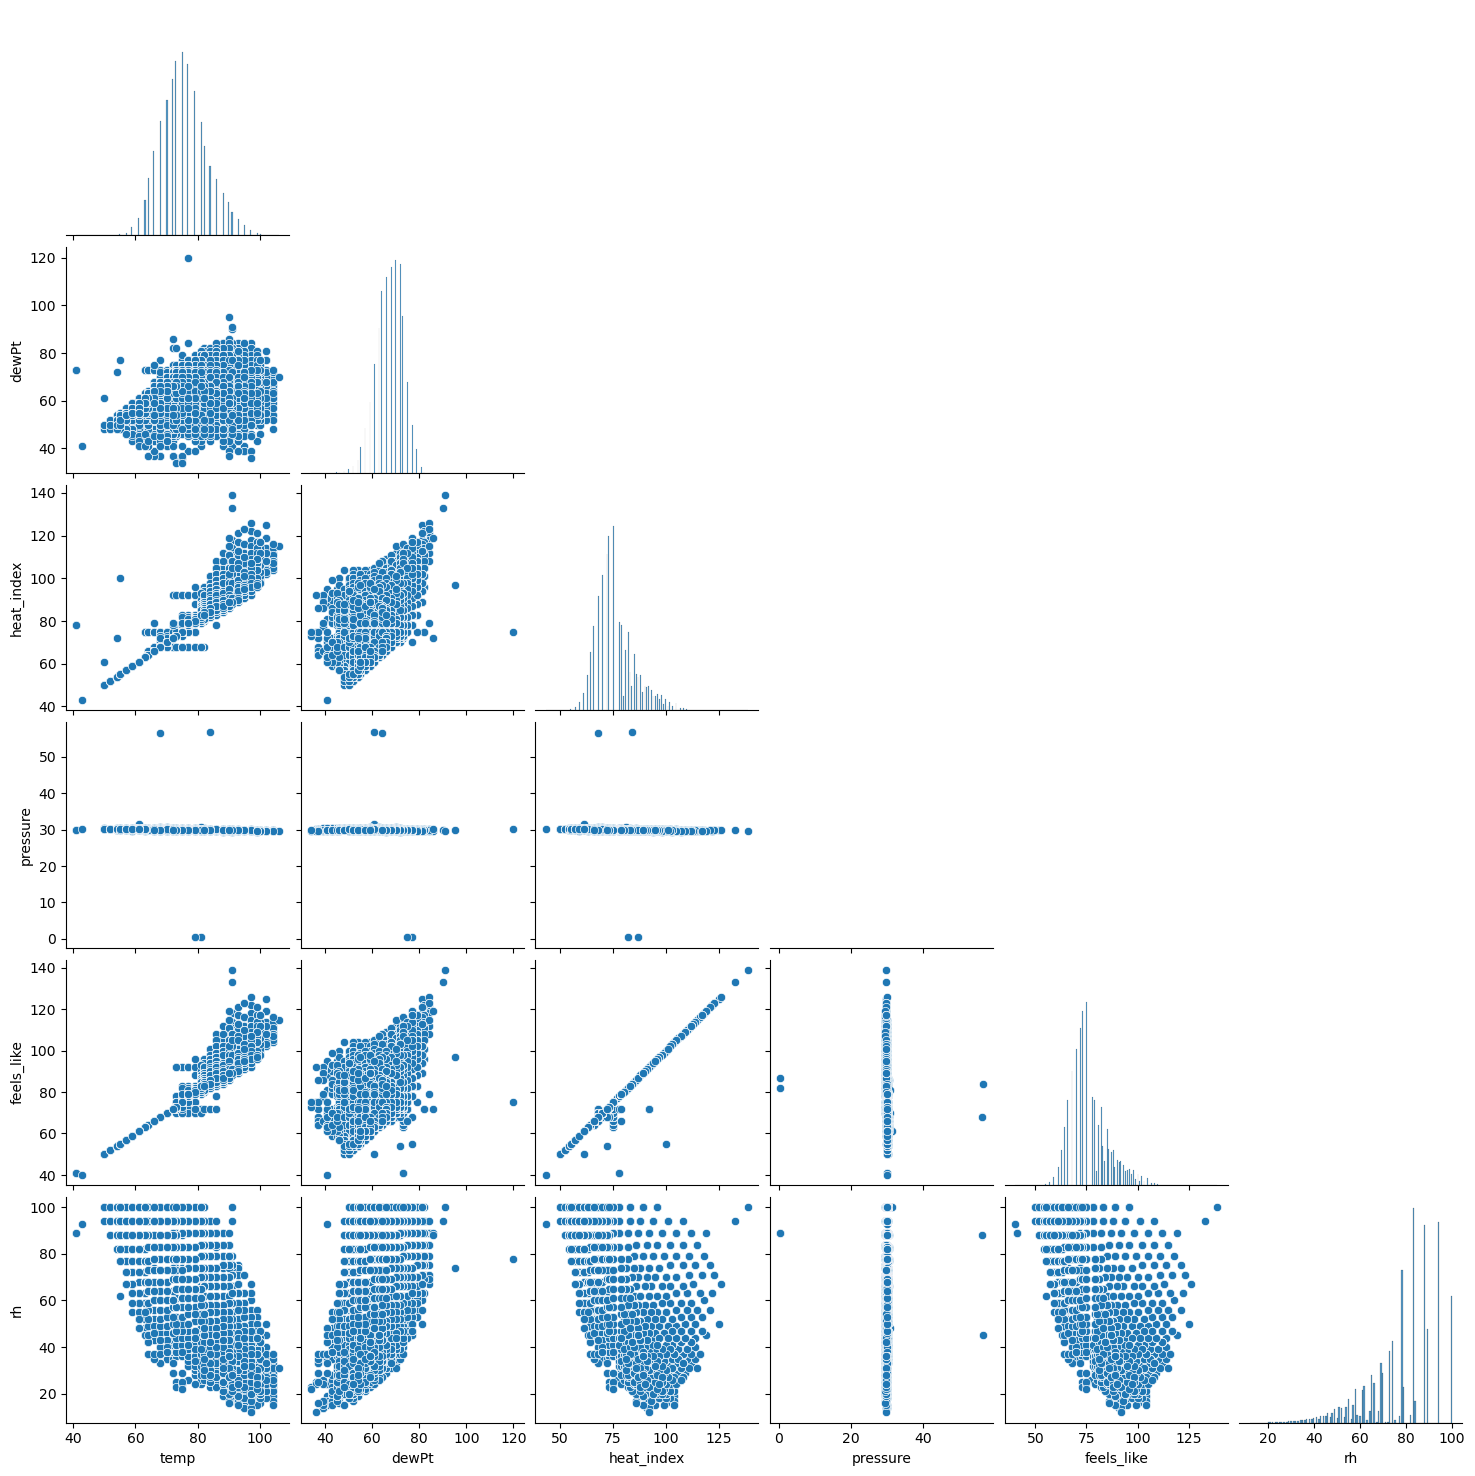

In [4]:
sns.pairplot(df[['temp','dewPt','heat_index','pressure','feels_like','rh']],corner=True)


# Filtrando e excluindo anomalias
Na visualização inicial, já é possível se deparar com gráficos de disperção bastante distorcidos, isto é um indicador da presença de outliers. Iremos verificar abaixo se é realmente o caso.
Sempre é dito que algum conhecimento de domínio é essencial para realizar análise de dados/predições. Vemos aqui um pequeno exemplo onde tal conhecimento pode ser extremamente útil

In [5]:
bool_low_temp = df['temp']<(np.mean(df['temp'])-4*np.std(df['temp']))
bool_low_heat_index = df['heat_index']<(np.mean(df['heat_index'])-4*np.std(df['heat_index']))
bool_low_pressure = df['pressure']<(np.mean(df['pressure'])-5*np.std(df['pressure']))
bool_high_pressure = df['pressure']>(np.mean(df['pressure'])+5*np.std(df['pressure']))
bool_dew_pt = df['dewPt']>(np.mean(df['dewPt'])+3*np.std(df['dewPt']))

bool_extreme_wind = df['wspd']>80

outlier_boolean = bool_high_pressure|bool_low_pressure|bool_low_temp|bool_low_heat_index|bool_extreme_wind|bool_dew_pt
df_exclude_outlier = df.loc[~outlier_boolean]
median_temp = df_exclude_outlier['temp'].median()
median_pressure = df_exclude_outlier['pressure'].median()
median_heat= df_exclude_outlier['heat_index'].median()
median_wind = df_exclude_outlier['wspd'].median()
median_dew = df_exclude_outlier['dewPt'].median()

df['temp'] = df['temp'].mask(outlier_boolean, median_temp)
df['heat_index'] = df['heat_index'].mask(outlier_boolean, median_heat)
df['pressure'] = df['pressure'].mask(outlier_boolean, median_pressure)
df['wspd'] = df['wspd'].mask(outlier_boolean,median_wind)
df['dewPt'] = df['dewPt'].mask(outlier_boolean,median_dew)

Se olharmos para a base de dados original, antes do pré-processamento, vemos velocidades de vento (`df[wspd]`), superiores a 150 milhas por hora. Caso esta medição esteja correta, isto implicaria em ventos com velocidades superiores a 241 km/h, tais ventos seriam grandes catástrofes naturais que não foram registradas. Isto ainda não é um motivo totalmente válido para descartar estes valores. A questão é que essas velocidades do vento em um determinado horário são seguidas por uma velocidade usual de vento, o que reforça ainda mais a tese de que tais valores são anômalos. Como sabemos que ventos fortes ainda podem ocorrer, optei por remover os registros com velocidade maior que 80 mph. Este valor foi escolhido com base nos valores do furacão Catarina de 2004, onde se registrou em Santa Catarina valores próximos a este, um evento extremamente raro.
https://ncics.org/ibtracs/index.php?name=v04r00-2004086S29318

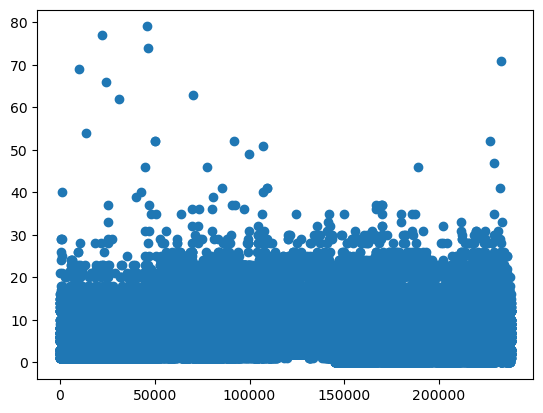

In [6]:
plt.scatter(x=df['wspd'].index,y=df['wspd'].values)

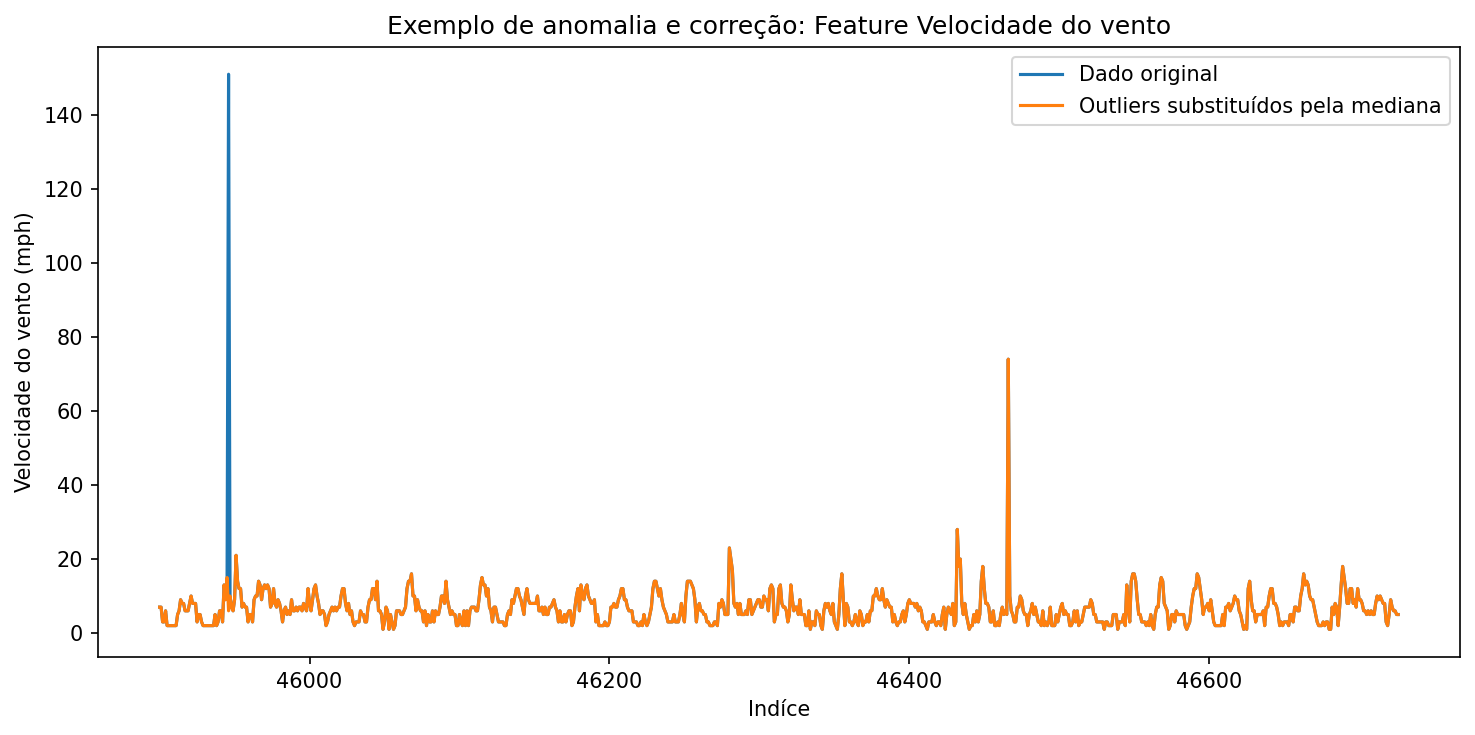

In [9]:
plt.figure(figsize=(10,5),dpi=150)
plt.title('Exemplo de anomalia e correção: Feature Velocidade do vento')
plt.xlabel("Indíce")
plt.ylabel("Velocidade do vento (mph)")
plt.tight_layout()
plt.plot(df_orig.iloc[45900:45727+1000]['wspd'],label='Dado original')
plt.plot(df.iloc[45900:45727+1000]['wspd'],label='Outliers substituídos pela mediana')
plt.legend()

# Visualização após uma simples remoção outliers

Podemos ver que se comparado ao dado original, os plots estão muito mais inteligíveis, como a variável `pressure`, onde um registro extremamente grande e outro muito pequeno, dificultavam a visualização dos gráficos de disperção. Agora, como se vê abaixo, tal problema foi resolvido.

<Figure size 2250x300 with 0 Axes>

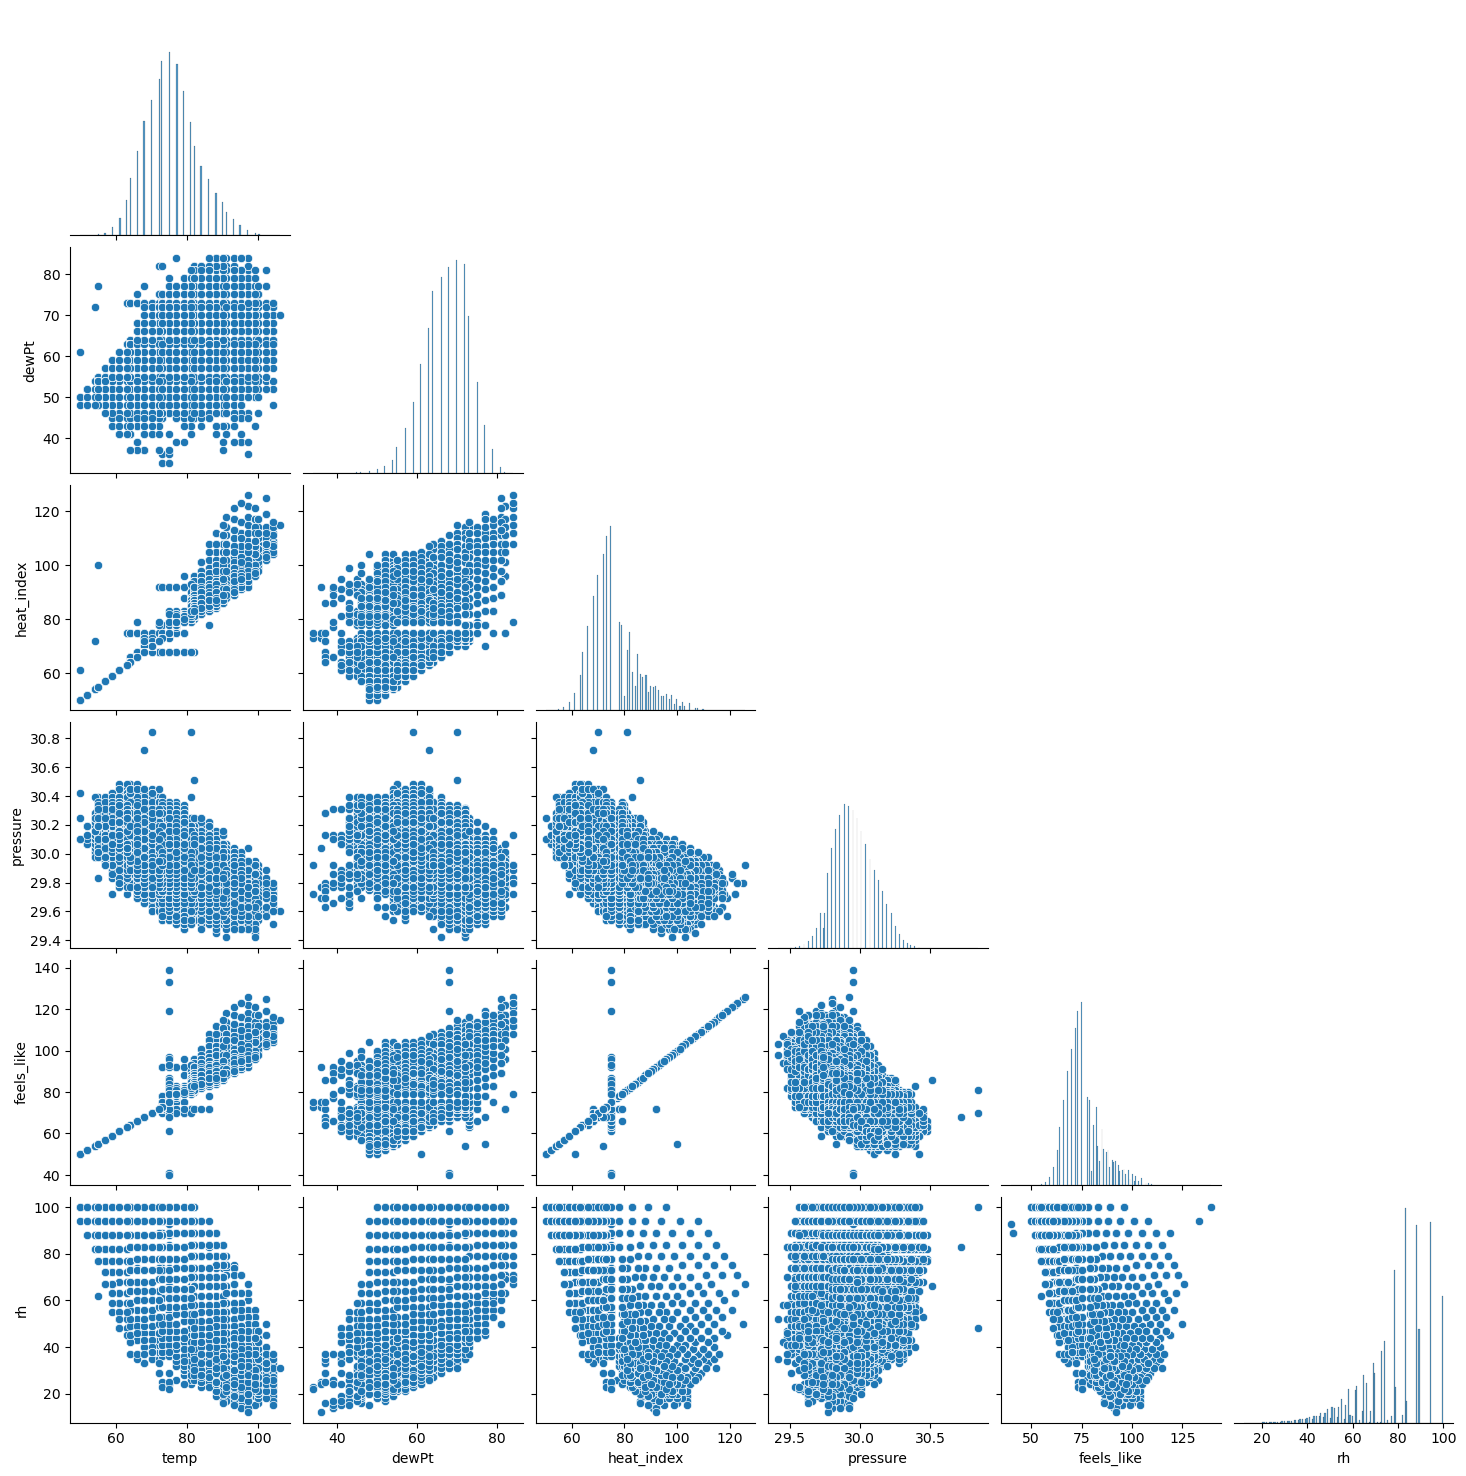

In [10]:
fig = plt.figure(figsize=(15,2),dpi=150)
sns.pairplot(df[['temp','dewPt','heat_index','pressure','feels_like','rh']],corner=True)

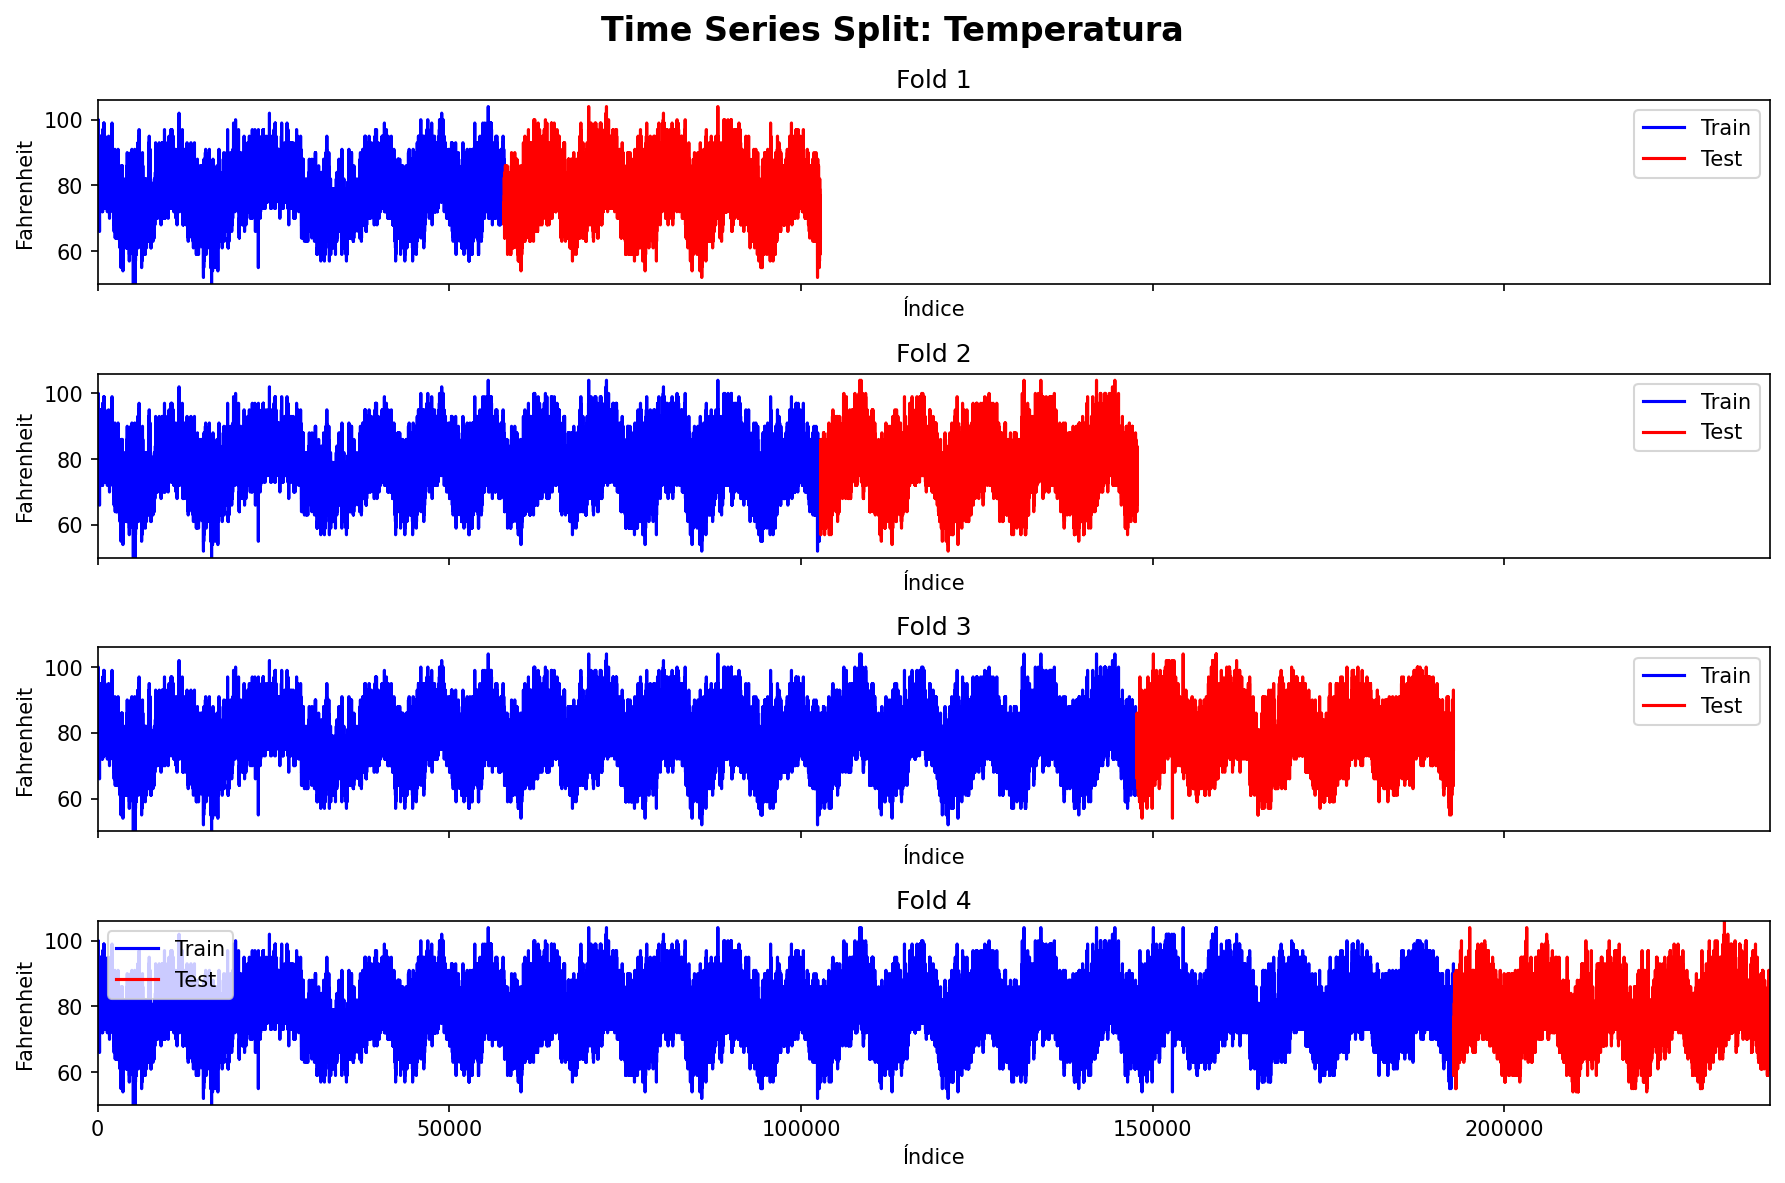

In [9]:
tss = TimeSeriesSplit(n_splits=4,test_size=45000)
n_splits = tss.get_n_splits()
temp = df['temp']
fold = 0
fig, axs = plt.subplots(n_splits,1,figsize=(12, 2*n_splits), dpi=150,sharex=True)

for train_idx,val_idx in tss.split(df):
    fold+=1
    ax = axs[fold-1]
    train = temp.iloc[train_idx]
    test = temp.iloc[val_idx]
    ax.plot(train.index, train.values, label='Train', color='blue')
    ax.plot(test.index, test.values, label='Test', color='red')
    
    ax.set_xlim(temp.index.min(), temp.index.max())
    ax.set_ylim(temp.min(), temp.max())
    
    ax.set_title(f'Fold {fold}')
    ax.set_xlabel('Índice')
    ax.set_ylabel('Fahrenheit')
    ax.legend()
fig.suptitle('Time Series Split: Temperatura', fontsize=16, fontweight='bold', ha='center', va='top')

plt.tight_layout()
plt.show()



# Pré-processamento: Normalização dos dados
Redes neurais recorrentes (e os algoritmos baseados em descida de gradiente no geral), são muito sensíveis a escala dos dados. Assim, normalizar os dados usualmente melhora a convergência dos modelos e a capacidade de aprendizado.

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

def build_rnn_model():
    with tf.device('/GPU:0'): 
        model = Sequential(name='single_cell_rnn')

        model.add(SimpleRNN(units=1, input_shape=(5,1),activation='tanh'))

        model.add(Dense(units=1))

        optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.005)
        model.compile(loss='mean_squared_error',optimizer=optimizer)
        model.summary()
    return model

In [11]:
def time_series_divide(df,samples=5):
    x_train = []
    y_train = []
    for i in range(len(df)-samples):
        x_train.append(df[i:i+samples])
        y_train.append(df[i+samples][0])
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    return x_train,y_train
def generate_data_split(df,ratio):
    training_size = int(np.floor(len(df)*ratio))
    df_train = df.iloc[:training_size].values
    df_test = df.iloc[training_size+1:].values
    
    #print("Training size"training_size)
    return df_train,df_test


In [71]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tss = TimeSeriesSplit(n_splits=5,test_size=45000)
n_splits = tss.get_n_splits()
temp = df['temp']
fold = 0
history_fit = []
results = []
for train_idx, val_idx in tss.split(df):
    scaler_train = StandardScaler()
    scaler_test = StandardScaler()
    fold += 1
    train = temp.iloc[train_idx]
    test = temp.iloc[val_idx]
    s_train = scaler_train.fit_transform(train.values.reshape(-1,1))
    s_test = scaler_test.fit_transform(test.values.reshape(-1,1))
    
    x_train,y_train = time_series_divide(s_train,5)
    x_test,y_test = time_series_divide(s_test,5)
    x_train = x_train[:,:,0]
    x_test = x_test[:,:,0]
    y_train = y_train.reshape(-1,1)
    with tf.device('/GPU:0'): 
        model = Sequential(name='single_cell_rnn')

        model.add(SimpleRNN(units=1, input_shape=(5,1),activation='relu'))

        model.add(Dense(units=1))
        optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.0009)

        model.compile(loss='mean_squared_error',optimizer=optimizer)
        fit_hist = model.fit(x_train,y_train,epochs=50,validation_data=(x_test,y_test),callbacks=[early_stopping])
        y_pred = model.predict(x_test)
        history_fit.append(fit_hist)
    mse = mean_squared_error(y_pred,y_test)
    results.append(mse)
    print(f"MSE Test - Fold {fold}: {mse}")

Epoch 1/50
450/450 [==============================] - 5s 9ms/step - loss: 0.9471 - val_loss: 0.2374
Epoch 2/50
450/450 [==============================] - 4s 9ms/step - loss: 0.1661 - val_loss: 0.1217
Epoch 3/50
450/450 [==============================] - 4s 9ms/step - loss: 0.1309 - val_loss: 0.1104
Epoch 4/50
450/450 [==============================] - 3s 8ms/step - loss: 0.1209 - val_loss: 0.1015
Epoch 5/50
450/450 [==============================] - 5s 10ms/step - loss: 0.1122 - val_loss: 0.0938
Epoch 6/50
450/450 [==============================] - 4s 10ms/step - loss: 0.1048 - val_loss: 0.0874
Epoch 7/50
450/450 [==============================] - 4s 9ms/step - loss: 0.0988 - val_loss: 0.0821
Epoch 8/50
450/450 [==============================] - 4s 9ms/step - loss: 0.0938 - val_loss: 0.0779
Epoch 9/50
450/450 [==============================] - 4s 9ms/step - loss: 0.0899 - val_loss: 0.0746
Epoch 10/50
450/450 [==============================] - 4s 9ms/step - loss: 0.0867 - val_loss: 0.07

# Resultado: Time-Series-Split

Percebe-se que em cada fold, o número de épocas necessárias até o early stopping vai diminuindo, isto se dá por alguns fatores: 

`*`  Pela própria maneira como o Time Series Split é estruturado, a cada fold o conjunto de treinamento vai aumentando, esse aumento no conjunto de treinamento pode fazer com que o modelo generalize melhor, assim alcançando a convergência mais rápidamente (menos épocas para early stopping).

`*` Batch size automático do TensorFlow, faz com que a cada fold o número de exemplos em cada batch aumente, desse modo é de se esperar que sejam necessário menos épocas para a convergência desejada.

OBS: Como o valor do parâmetro `patience` está relativamente baixo, `patience = 4`, isto acentua ainda mais este comportamento (redução do número de épocas com o aumento de folds.)




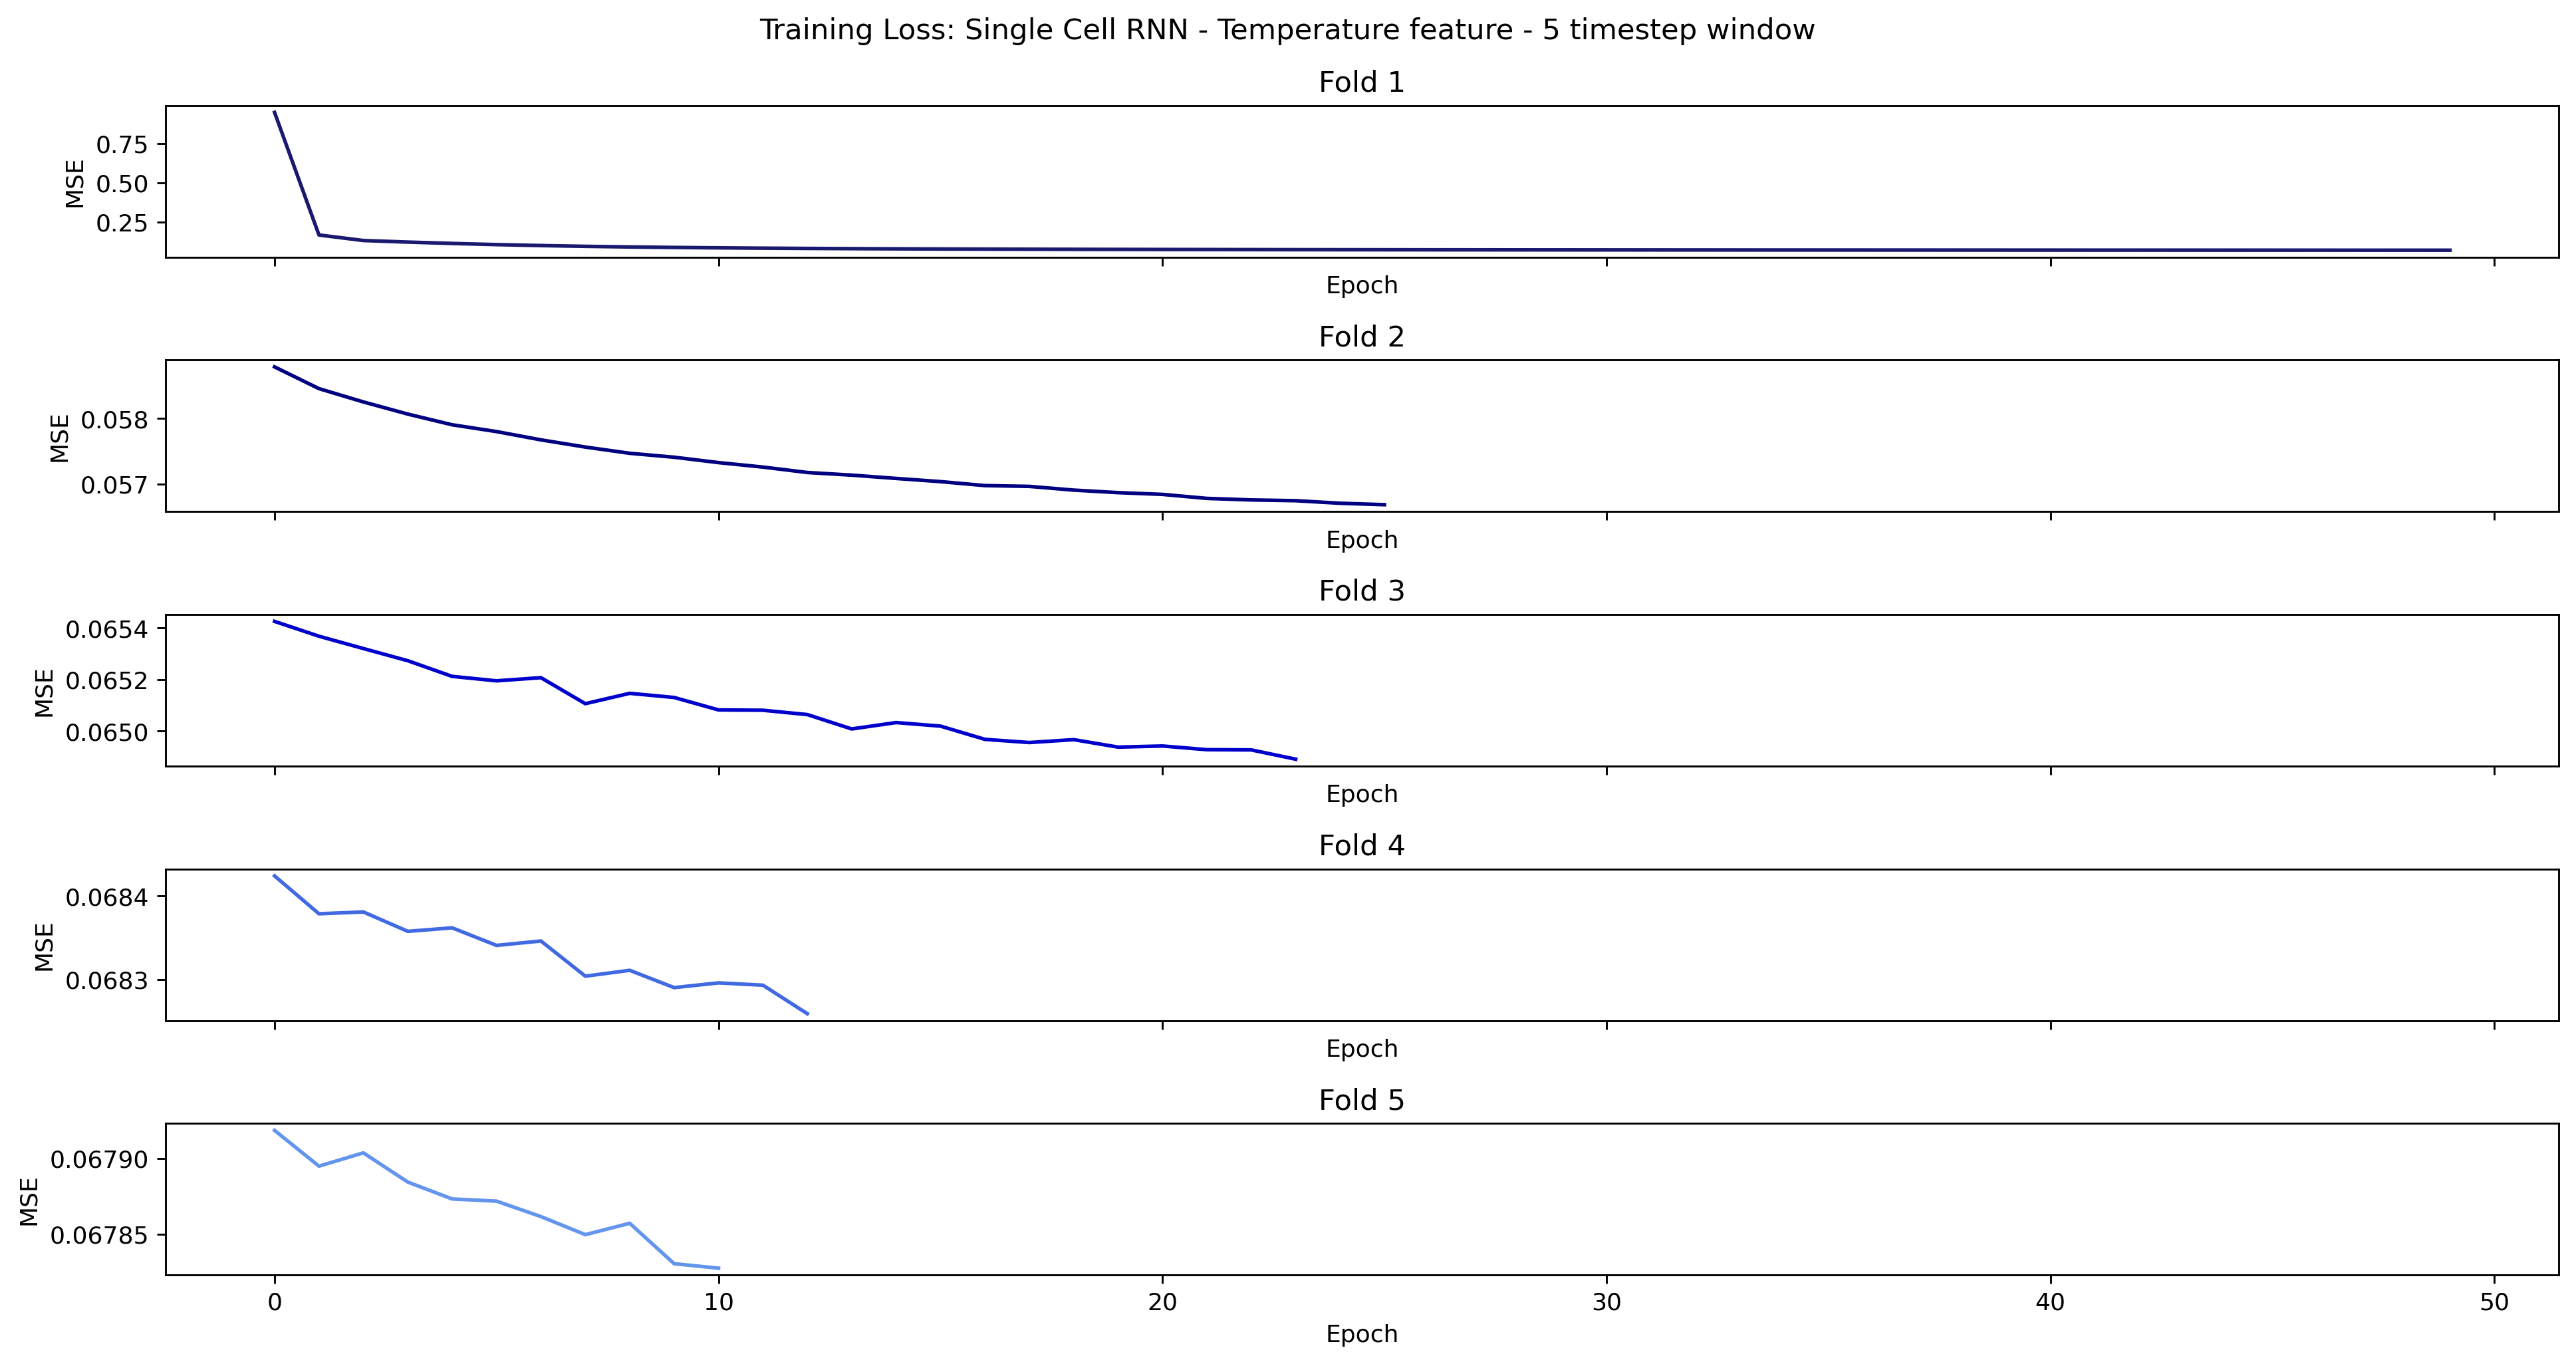

In [72]:
blues = ['midnightblue','navy','mediumblue','royalblue','cornflowerblue']
fig, axs = plt.subplots(n_splits,1,figsize=(15, 8),dpi=260,sharex=True)
fig.suptitle("Training Loss: Single Cell RNN - Temperature feature - 5 timestep window")
for i in range(5):
    ax = axs[i]
    ax.set_title(f'Fold {i+1}')
    ax.set_ylabel("MSE")
    ax.set_xlabel("Epoch")
    ax.plot(history_fit[i].history['loss'],color=blues[i])
fig.tight_layout()


In [57]:
def build_rnn_model(units=10,seq_len=5):
    with tf.device('/GPU:0'): 
        model = Sequential(name='single_cell_rnn')

        model.add(SimpleRNN(units=units, input_shape=(seq_len,1),activation='relu'))

        model.add(Dense(units=1))

        optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.005)
        model.compile(loss='mean_squared_error',optimizer=optimizer)
        model.summary()
    return model

In [17]:
from sklearn.preprocessing import StandardScaler

def validate_seq_len(df,len_size=5):
    train = generate_data_split(df['temp'],0.95)[0].reshape(-1,1)
    test = generate_data_split(df['temp'],0.95)[1].reshape(-1,1)

    scaler_train = StandardScaler()
    scaler_test = StandardScaler()
    s_train = scaler_train.fit_transform(train)
    s_test = scaler_test.fit_transform(test)
        
    x_train,y_train = time_series_divide(s_train,len_size)
    x_test,y_test = time_series_divide(s_test,len_size)

    x_train = x_train[:,:,0]
    x_test = x_test[:,:,0]
    y_train = y_train.reshape(-1,1)
    y_test = y_test.reshape(-1,1)
    return x_train,x_test,y_train,y_test


def validate_tss(df,train_idx,val_idx,len_size=5):
    scaler_train = StandardScaler()
    scaler_test = StandardScaler()
    train = temp.iloc[train_idx]
    test = temp.iloc[val_idx]
    s_train = scaler_train.fit_transform(train.values.reshape(-1,1))
    s_test = scaler_test.fit_transform(test.values.reshape(-1,1))
    
    x_train,y_train = time_series_divide(s_train,len_size)
    x_test,y_test = time_series_divide(s_test,len_size)
    x_train = x_train[:,:,0]
    x_test = x_test[:,:,0]
    y_train = y_train.reshape(-1,1)

    return x_train,x_test,y_train,y_test    

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
tf.autograph.set_verbosity(0)
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tss = TimeSeriesSplit(n_splits=5,test_size=500)
n_splits = tss.get_n_splits()
fold = 0
history_fit_total = []
history_mse_total = []
num_rows = len(df)
last_tenth = num_rows // 20

# Get the last 5% datarows of the DataFrame

# For validation, using the entire dataset would be extremely costly.

# Due to the nature of the weather data, using a reduced number of samples should not be a problem


tiny_df = df.iloc[-last_tenth:]
len_sizes = [6,24,48,144]


for len_size in len_sizes:
    history_mse = []
    for train_idx, val_idx in tss.split(tiny_df):

        fold +=1
        x_train,x_test,y_train,y_test =validate_tss(tiny_df,train_idx,val_idx,len_size=len_size)

        model = build_rnn_model(units=10,seq_len=len_size)
        with tf.device('/GPU:0'): 
            fit_hist = model.fit(x_train,y_train,epochs=25,validation_data=(x_test,y_test),callbacks=[early_stopping])
            y_pred = model.predict(x_test)
        mse = mean_squared_error(y_pred,y_test)
        history_mse.append(mse)
        print(f"Sequence Lenght = {len_size}, Fold = {fold}, MSE = {mse}")
    total_mean_mse = np.mean(history_mse)
    history_mse_total.append(total_mean_mse)
    print(f"Sequence Lenght = {len_size}, Mean Total MSE = {total_mean_mse}")

    fold=0
dict_results = {"len_sizes":len_sizes,"history_mse":history_mse_total}
results_df = pd.DataFrame(dict_results)
results_df.to_csv("Data/TimeSeriesCV.csv")

Model: "single_cell_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_106 (SimpleRNN)  (None, 10)                120       
                                                                 
 dense_106 (Dense)           (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25


ValueError: in user code:

    File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "single_cell_rnn" is incompatible with the layer: expected shape=(None, 6, 1), found shape=(None, 5)


In [45]:
results_df.sort_values('history_mse')

,len_sizes,history_mse
2,48,0.055590
1,24,0.056542
0,6,0.056905
3,144,0.058824


In [54]:
scaler_train = StandardScaler()
scaler_test = StandardScaler()
model = build_rnn_model(units=10)
train,test = generate_data_split(df=df["temp"],ratio=0.95)
s_train = scaler_train.fit_transform(train.reshape(-1,1))
s_test = scaler_test.fit_transform(test.reshape(-1,1))
x_train,y_train = time_series_divide(s_train,48)
x_test,x_test = time_series_divide(s_train,48)

#model = build_rnn_model(units=10)
#with tf.device('/GPU:0'): 
#fit_hist = model.fit(x_train,y_train,epochs=25,validation_data=(x_test,y_test),callbacks=[early_stopping])
x_test


Model: "single_cell_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_103 (SimpleRNN)  (None, 10)                120       
                                                                 
 dense_103 (Dense)           (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


array([ 0.18933862, -0.0806784 , -0.0806784 , ..., -0.35069542,
       -0.35069542, -0.35069542])